# Loading and formatting the data


In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("homework2_data.csv", na_values=99999)

In [4]:
df.head()

,recid,boro,uf1_1,uf1_2,uf1_3,uf1_4,uf1_5,uf1_6,uf1_7,uf1_8,...,hflag4,hflag18,uf52h_h,uf52h_a,uf52h_b,uf52h_c,uf52h_d,uf52h_e,uf52h_f,uf52h_g
0,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
1,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,0,0,0,0
2,1,1,9,9,9,9,1,9,9,9,...,0,0,1,1,1,0,1,0,1,0
3,1,1,9,9,9,9,1,9,9,9,...,0,0,0,0,0,0,0,0,0,0
4,1,1,9,9,9,9,1,9,9,9,...,0,0,1,0,0,0,1,0,0,0


We remove the observation with no value for the dependent variable and select the dependent variable

In [5]:

no_rent = df.uf17.isnull()

In [6]:
df_rent = df[~no_rent]

In [7]:
rent = df_rent.uf17
data = df_rent.drop("uf17", axis=1)
data = data.drop("race1", axis=1)

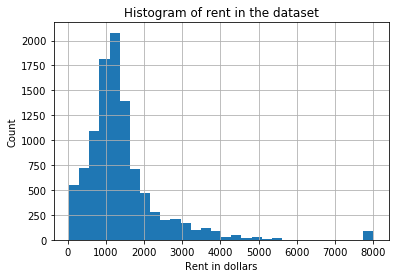

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
ax = rent.hist(bins=30)
ax.set_xlabel('Rent in dollars')
ax.set_ylabel('Count')
ax.set_title('Histogram of rent in the dataset')

We are going to selec only the columns that have a non zero variance.
The other having no predictive power whatsoever

In [9]:

non_const_columns = data.var(axis=0) > 0

In [10]:
data.var(axis=0).head()

recid    0.000000
boro     1.128930
uf1_1    0.703268
uf1_2    0.173160
uf1_3    0.451671
dtype: float64

In [11]:
data_ = data[data.columns[non_const_columns]]

In [12]:
data_.shape

(10229, 174)

We are also going to impute the dataset using the median strategy to replace
the missing values in the independant variables.
We are aware that using the same dataset for imputation and then for learning might
introduce some information leakage but it is an issue we chose not to address here
to simplify the problem.
One could alternatively choose to use the imputation inside of a pipeline

In [13]:
from sklearn.preprocessing import Imputer
X = Imputer(strategy="median").fit_transform(data_.values)

In [14]:
X.shape

(10229, 174)

In [15]:
rent.values.shape

(10229,)

In [16]:
import numpy as np

We are now going to assess the feature importance using univariate linear regression
score for each variable.
This is a good way to do feature selection for example

In [17]:
from sklearn.feature_selection import f_regression
F, p = f_regression(X, rent.values)
inds_F = np.argsort(F)

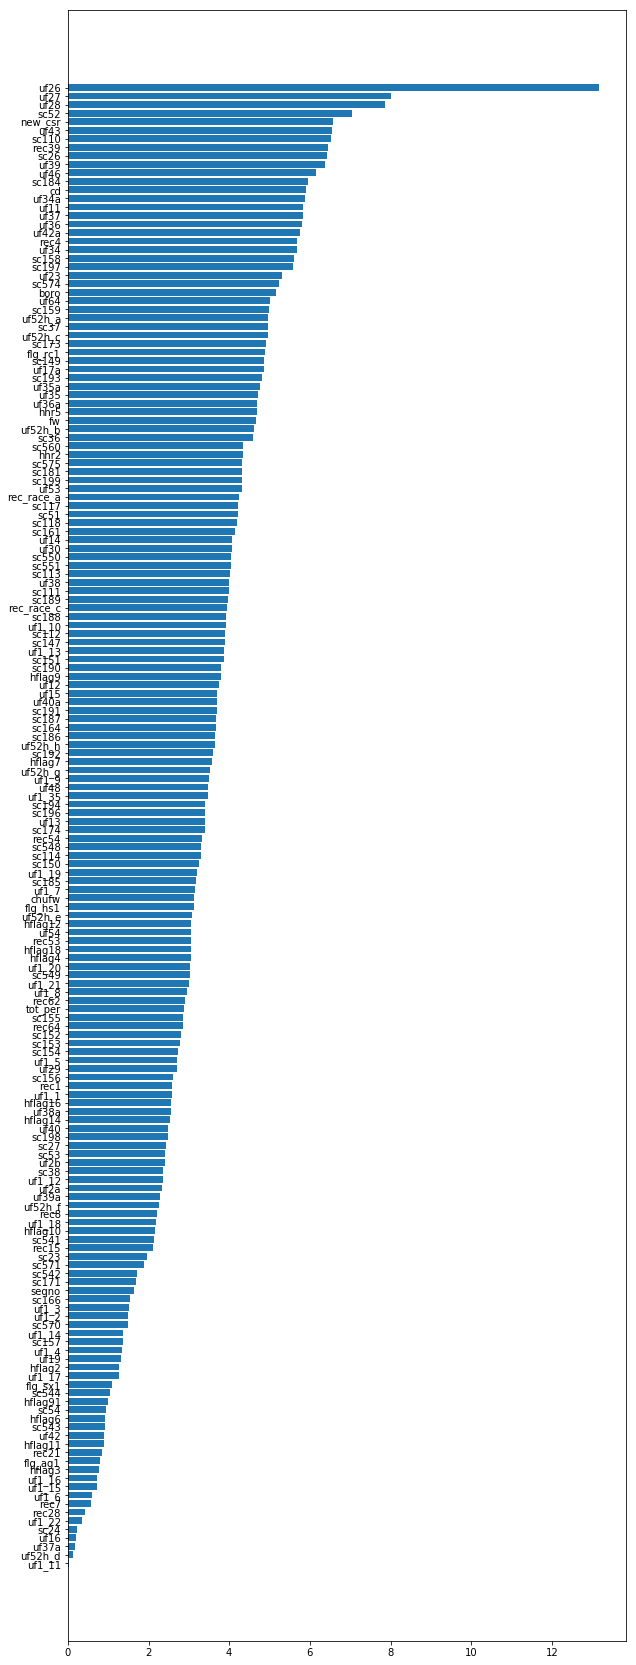

In [18]:
#plt.figure(figsize=(10, 50))
#plt.barh(np.arange(len(F)), np.log(F + 1))
#plt.yticks(np.arange(len(F)), data_.columns);

plt.figure(figsize=(10, 30))
plt.barh(np.arange(len(F)), np.log(F[inds_F] + 1))
plt.yticks(np.arange(len(F)), data_.columns[inds_F]);

The next few cell involve some processing of an excel file containing the
description of each variables

In [19]:
raw_variables = pd.read_excel("occ_14_long.xls", skiprows=4)
# drop repeats of the header
raw_variables = raw_variables[raw_variables['Variable Name'] != "Variable Name"]


In [20]:
raw_variables.head()

,Character Position,Item Number,Item Name,Source Code,Variable Name,Unnamed: 5,Code and Description
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,Record Type,NaN,NaN,NaN,1=OCCUPIED


In [21]:
variables = raw_variables.dropna(subset=['Variable Name'])
variables.head()

,Character Position,Item Number,Item Name,Source Code,Variable Name,Unnamed: 5,Code and Description
6,2,NaN,Borough,Label,boro,NaN,1=Bronx
12,3-8,D,Condition of External Walls,001,UF1_1,NaN,"Missing bricks, siding, or other outside wall ..."
13,NaN,NaN,NaN,002,UF1_2,NaN,Sloping or bulging outside walls
14,NaN,NaN,NaN,003,UF1_3,NaN,Major cracks in outside walls
15,NaN,NaN,NaN,004,UF1_4,NaN,"Loose or hanging cornice, roofing, or other ma..."


In [22]:
# sometimes two variable names correspond to the same item
# the first variable starts with rec and they are in directly adjacent rows
for i, row in variables.iterrows():
    if i - 1 in variables.index:
        # the row above also has a variable name
        row_above = variables.loc[i-1]
        if row_above['Variable Name'].startswith("REC"):
            # this is one of the culprits
            #print(row)
            #print(row_above)
            # replace UF row with REC row
            variables.loc[i]['Item Name'] = variables.loc[i-1]['Item Name']

In [23]:
mask = variables['Item Name'].isnull()
variables = variables.copy()  # variables is a slice of a dataframe and not a dataframe before this.
variables['Item Name'][mask] = variables['Code and Description'][mask]
variables['Variable Name'] = variables['Variable Name'].str.strip(",").replace("SEX/HHR2", "HHR2")

In [24]:
variables = variables.set_index(variables['Variable Name'].str.lower())
variables.loc['uf43']['Item Name'] = variables.loc['hhr3t']['Item Name'] # manual fix ...
variables.head()

,Character Position,Item Number,Item Name,Source Code,Variable Name,Unnamed: 5,Code and Description
Variable Name,,,,,,,
boro,2,NaN,Borough,Label,boro,NaN,1=Bronx
uf1_1,3-8,D,Condition of External Walls,001,UF1_1,NaN,"Missing bricks, siding, or other outside wall ..."
uf1_2,NaN,NaN,Sloping or bulging outside walls,002,UF1_2,NaN,Sloping or bulging outside walls
uf1_3,NaN,NaN,Major cracks in outside walls,003,UF1_3,NaN,Major cracks in outside walls
uf1_4,NaN,NaN,"Loose or hanging cornice, roofing, or other ma...",004,UF1_4,NaN,"Loose or hanging cornice, roofing, or other ma..."


In [25]:
item_name = variables['Item Name']
item_name.head()

Variable Name
boro                                               Borough
uf1_1                          Condition of External Walls
uf1_2                     Sloping or bulging outside walls
uf1_3                        Major cracks in outside walls
uf1_4    Loose or hanging cornice, roofing, or other ma...
Name: Item Name, dtype: object

In [26]:
source_codes = raw_variables.dropna(subset=['Source Code']).copy()
source_codes['Source Code'] = source_codes['Source Code'].astype("str").str.lstrip("0")
source_codes = source_codes.drop_duplicates(subset=["Source Code"])

In [27]:
sc_reindex = source_codes.set_index("sc" + source_codes['Source Code'])

In [28]:
source_code_series = sc_reindex['Item Name']

In [29]:
feature_mapping = {}
for c in data_.columns:
    if c in item_name.index:
        feature_mapping[c] = item_name.loc[c]
    elif c in source_code_series.index:
        feature_mapping[c] = source_code_series.loc[c]
    else:
        print(c)
feature_mapping['seqno'] = "seqno"

seqno


In [30]:
data_desc = data_.rename_axis(item_name, axis=1)
data_desc = data_desc.rename_axis(source_code_series, axis=1)

We are now able to make more sense of the important variable by using their 
actual description

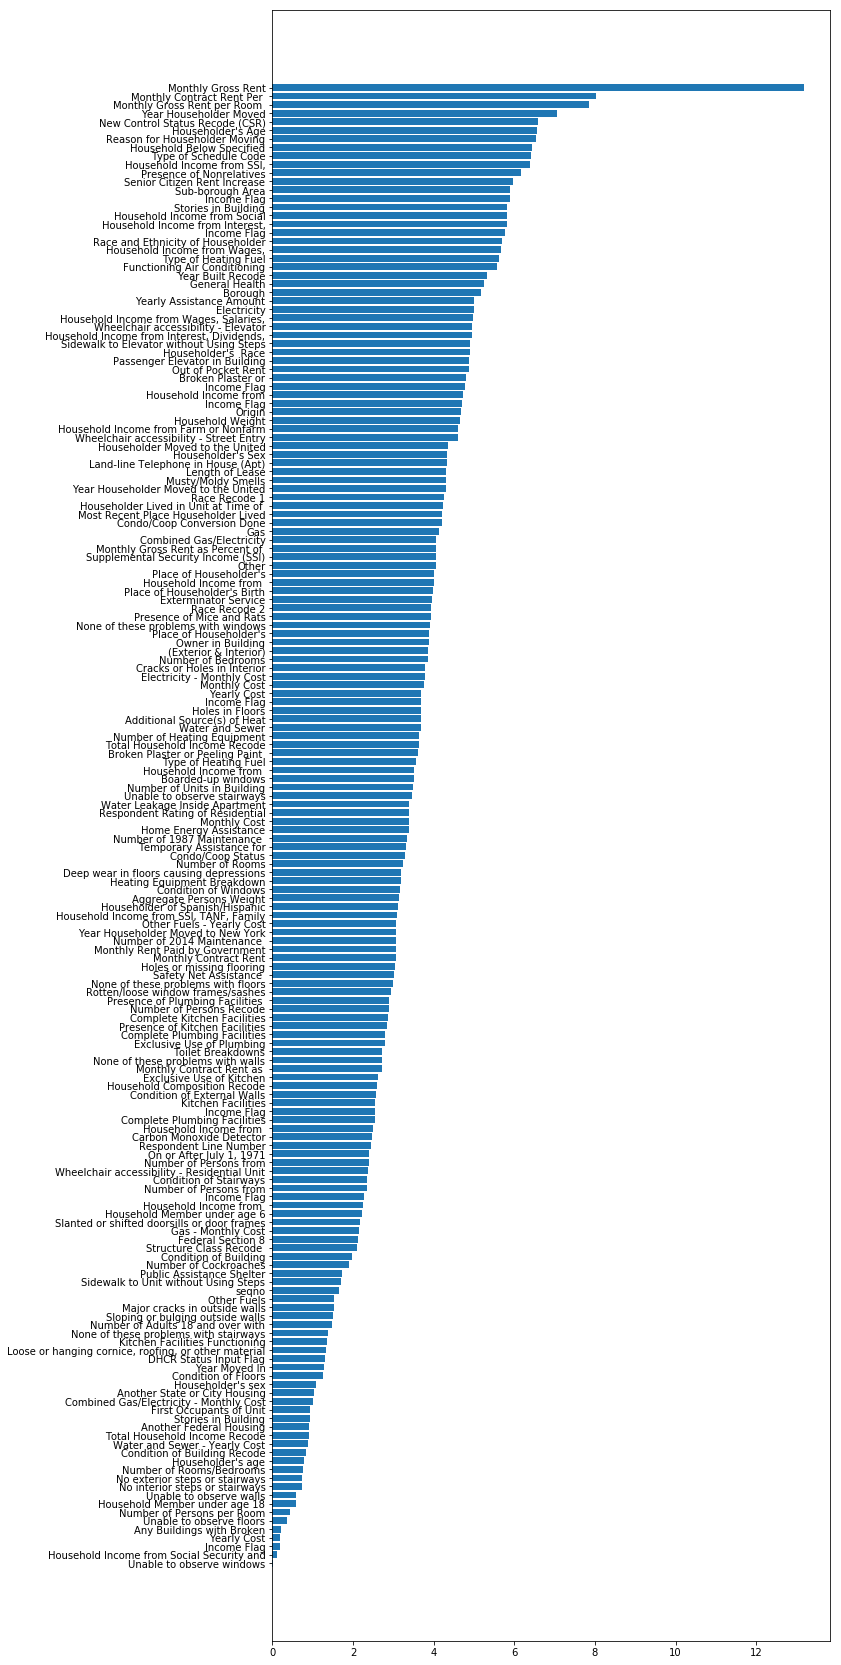

In [31]:
#plt.figure(figsize=(10, 50))
#plt.barh(np.arange(len(F)), np.log(F + 1))
#plt.yticks(np.arange(len(F)), data_desc.columns);

plt.figure(figsize=(10, 30))
plt.barh(np.arange(len(F)), np.log(F[inds_F] + 1))
plt.yticks(np.arange(len(F)), data_desc.columns[inds_F]);


An alternative method of assessing feature importances is using the mutual information
regression that can capture non linear dependance between a feature and the response 
variable but is more computer intensive.

In [32]:

from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, rent.values)
inds = np.argsort(mi)


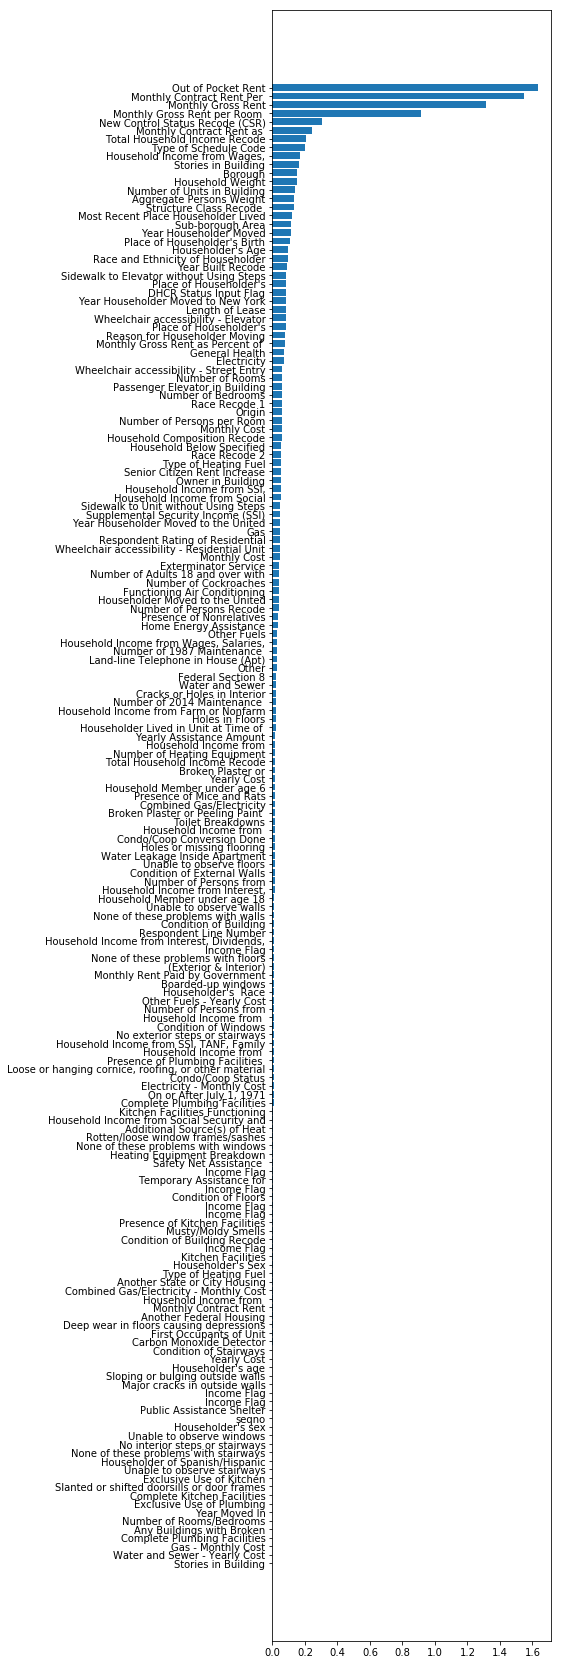

In [33]:
plt.figure(figsize=(5, 30))
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), map(lambda x: feature_mapping[x], data_.columns[inds]));

In [34]:
np.where(data_desc.columns == "Kitchen Facilities Functioning")

(array([58], dtype=int64),)

Now we can see clearly that the out of our remaining features, the only one that
make sense to predict a market price of the houses are the ones that are not 
related to the renter, so we are onl going to keep those.

In [35]:

non_renter_columns = data_.columns[:58 + 1]
non_renter_columns = [i for i in non_renter_columns if "Householder" not in feature_mapping[i] and "Number of Persons from" not in feature_mapping[i] and "Origin" not in feature_mapping[i]]
non_renter_columns += ["new_csr"]

In [36]:
data_nr = data_[non_renter_columns]

We are now going to reapply both our feature importance methods to the features
not related to the renter after imputing them

In [37]:

X = Imputer(strategy="median").fit_transform(data_nr.values)
F, p = f_regression(X, rent.values)
inds_F = np.argsort(F)

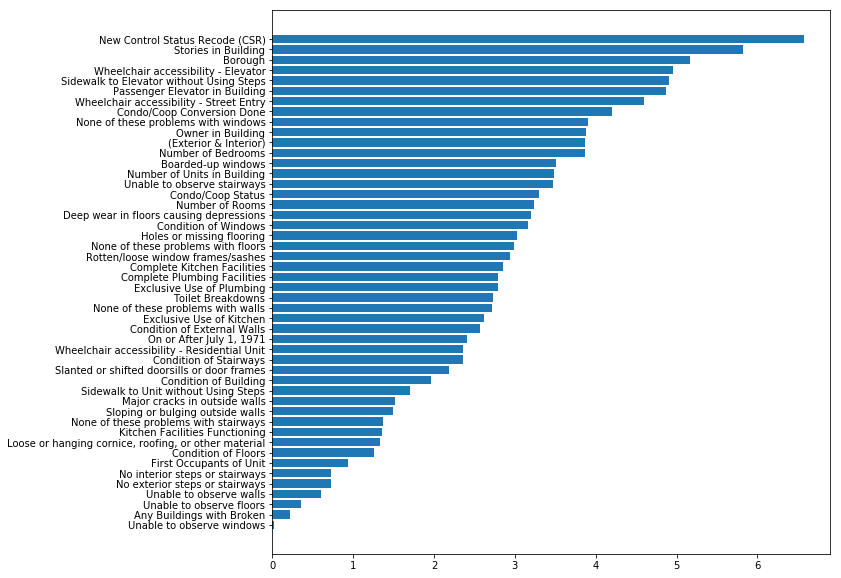

In [38]:
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(F)), np.log(F[inds_F] + 1))
#plt.yticks(np.arange(len(F)), map(lambda x: feature_mapping[x], data_nr.columns));
plt.yticks(np.arange(len(F)), map(lambda x: feature_mapping[x], data_nr.columns[inds_F]));

In [39]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, rent.values)
inds = np.argsort(mi)

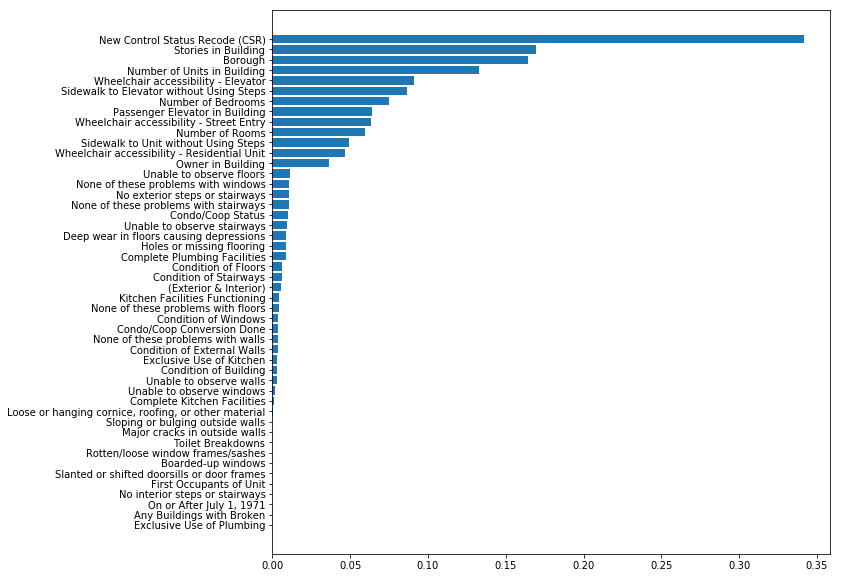

In [40]:
plt.figure(figsize=(10, 10))
plt.barh(np.arange(len(mi)), mi[inds])
plt.yticks(np.arange(len(mi)), map(lambda x: feature_mapping[x], data_nr.columns[inds]));

We can now select a certain percentage of the features to integrate to our model based
on one of our feature importance metrics

In [41]:

from sklearn.feature_selection import SelectPercentile
select = SelectPercentile(mutual_info_regression, percentile=50)

In [42]:
select.fit(X, rent.values)

SelectPercentile(percentile=50,
         score_func=<function mutual_info_regression at 0x00000152ADE666A8>)

This are the description of the features we get when selecting the 50% most important

In [43]:

feature_names = [feature_mapping[x] for x in data_nr.columns[select.get_support()]]
feature_names

['Borough',
 'Loose or hanging cornice, roofing, or other material',
 'Condition of Windows',
 'Boarded-up windows',
 '(Exterior & Interior)',
 'None of these problems with stairways',
 'Condition of Floors',
 'None of these problems with floors',
 'Wheelchair accessibility - Street Entry',
 'Wheelchair accessibility - Elevator',
 'Wheelchair accessibility - Residential Unit',
 'On or After July 1, 1971',
 'Condo/Coop Conversion Done',
 'Number of Units in Building',
 'Owner in Building',
 'Stories in Building',
 'Passenger Elevator in Building',
 'Sidewalk to Elevator without Using Steps',
 'Sidewalk to Unit without Using Steps',
 'Number of Rooms',
 'Number of Bedrooms',
 'Toilet Breakdowns',
 'Kitchen Facilities Functioning',
 'New Control Status Recode (CSR)']

In [67]:
X_selected = select.transform(X)

In [45]:
len(feature_names)

24

In [46]:
y = rent.values

We can now draw a scatter plot with the dependent variable for each of the selected
features. 
The first thing that becomes apparent is that all the selected features are
discrete.
Therefore, we want to use an algorithm that can work properly with discrete features

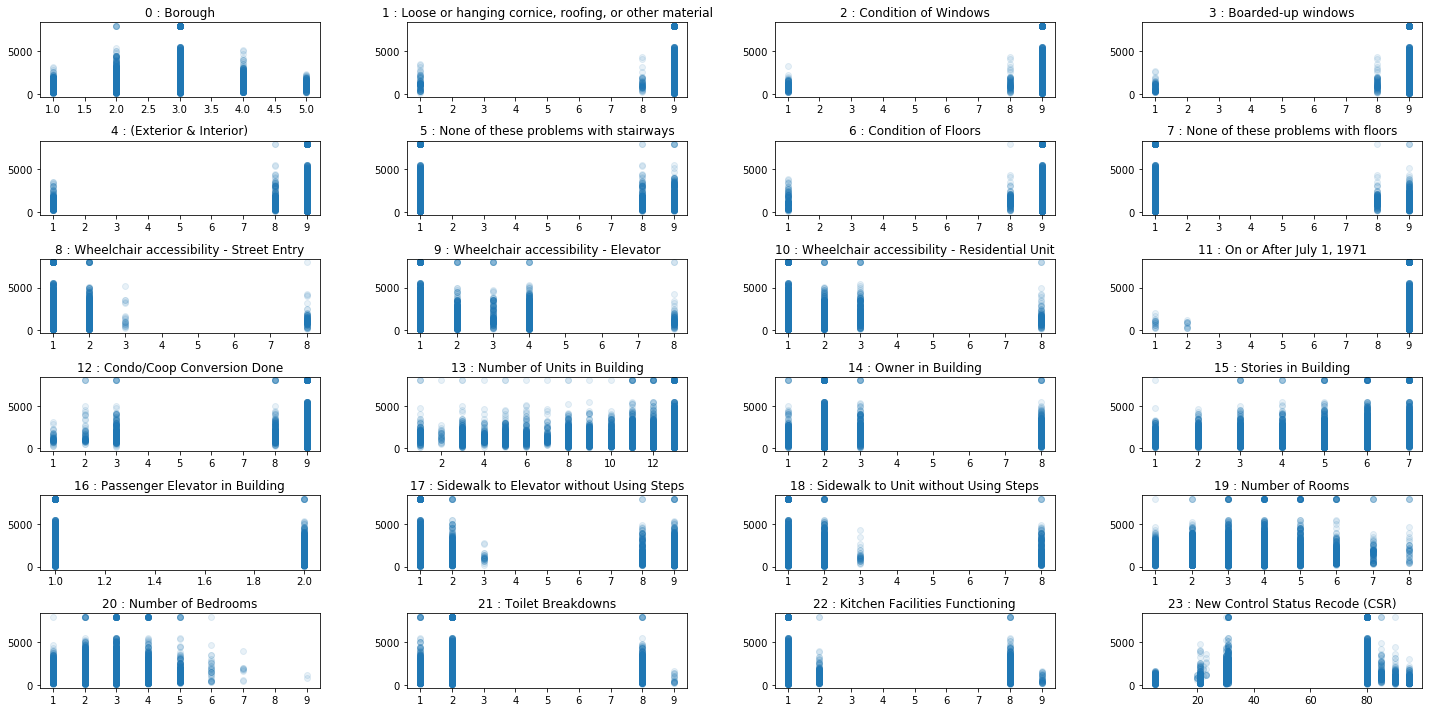

In [47]:

fig, axes = plt.subplots(6, 4, figsize=(20, 10))
for i, (name, ax) in enumerate(zip(feature_names, axes.ravel())):
    ax.scatter(X_selected[:, i], y, alpha=.1)
    ax.set_title("{} : {}".format(i, name))
plt.tight_layout()

In [48]:
X.shape

(10229, 48)

In order to be able to estimate the performanc of our model, a standard procedure
is to divide the dataset into a training part on which we are going to learn the
actual model and an evaluation part on which we are going to test the learned model

In [49]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected, y, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

Given the discrete nature of the data, we choose a random forest regressor model
that is very suitable for that task.
Non linear relationships can also be capture which allow to learn more complex models

In [50]:

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100).fit(X_train, y_train)
rf.score(X_val, y_val)

0.4780959746494714

We can now resort our feature by to importance based on the random forest model

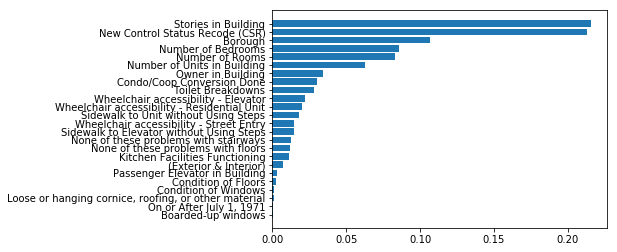

In [51]:

inds_rf_fi = list(np.argsort(rf.feature_importances_))
plt.barh(range(X_train.shape[1]), rf.feature_importances_[inds_rf_fi])
plt.yticks(range(X_train.shape[1]), map(lambda x: feature_names[x], inds_rf_fi));
#inds_rf_fi

We can compare the performance of our previous model with the one of the simplest 
one the would be a simple linear regression

In [52]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
lr.score(X_val, y_val)

0.19418212754374953

The reason for such a poor performance for the linear model is that it makes the
underlying that the different values for each feature are ordered (which is wrong)
and use that order.
To adress that issue, the standard procedure is to create a binary varable for each
possible value of each feature stating if for the given observation the feature
had that specific value. This is called one-hot-encoding.

In [53]:

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder().fit(X_train)

We can now retrain a linear regression model using this transformation of the data
as we can see, the new model performs way better

In [54]:

from sklearn.pipeline import make_pipeline
ohe_pipe = make_pipeline(OneHotEncoder(), LinearRegression())
ohe_pipe.fit(X_train, y_train).score(X_val, y_val)

0.48763916433311205

In [54]:
feature_names

['Borough',
 'Boarded-up windows',
 'Condition of Stairways',
 '(Exterior & Interior)',
 'Unable to observe stairways',
 'Condition of Floors',
 'Unable to observe floors',
 'Any Buildings with Broken',
 'Wheelchair accessibility - Street Entry',
 'Wheelchair accessibility - Elevator',
 'Wheelchair accessibility - Residential Unit',
 'First Occupants of Unit',
 'Condo/Coop Status',
 'Condo/Coop Conversion Done',
 'Number of Units in Building',
 'Owner in Building',
 'Stories in Building',
 'Passenger Elevator in Building',
 'Sidewalk to Elevator without Using Steps',
 'Sidewalk to Unit without Using Steps',
 'Number of Rooms',
 'Number of Bedrooms',
 'Kitchen Facilities Functioning',
 'New Control Status Recode (CSR)']

I have talked very quickly about this issue previously but performing any kind of
imputation/transformation of the data can be seen as learning some information
already. Hence, performing those operations and then learning the model on the same data
might lead to some information leakage which might lead to an overestimation of
the model performance. 
For example, when imputing data using the mean, if one computes the mean using both the 
training and test data then one is using the information about the test data that 
is conveyed by is contribution to the mean calculation which is likelyto improve
the performancd of a model learned on the imputed dataset. 
Furthermore, this would be impossible to replicate if one was given a train datset 
first and a test one only afterward.
To adress this issue, all this transformations of the data should also be learned
on the training set solely and then only applied on the test set before evaluating
the model on it.
This is exactly what sckit learn pipelines are for.

In [59]:


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoLarsCV, Lars, Ridge, LassoLars
from sklearn.feature_selection import VarianceThreshold

ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                                      RidgeCV())
ohe_interactions_pipe.fit(X_train, y_train).score(X_val, y_val)


0.51728825297419179

In [56]:
# converting the interactions to a sparse matrix is slightly faster
# - or not!
# ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(),
#                                      FunctionTransformer(lambda X: sp.csr_matrix(X)), RidgeCV())
#ohe_interactions_pipe.fit(X_train, y_train).score(X_val, y_val)

To visualize our predictions, we can scatterplot the predicted rent values
against the real values for the observation in the test dataset

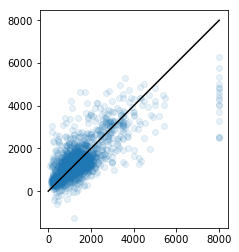

In [60]:

plt.scatter(y_val, ohe_interactions_pipe.predict(X_val), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, 8000], [0, 8000], c='k')

We can also draw an histogram of the residuals

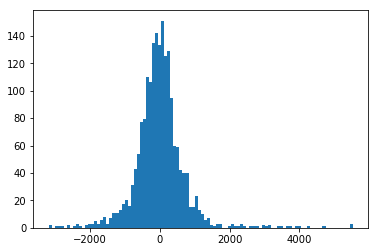

In [61]:

plt.hist(y_val - ohe_interactions_pipe.predict(X_val), bins=100);

Another convenient feature of the pipeline is the ability to easily add or remove
any step we see fit in the creation of the model.
For example, we can add a variance threshold for the features after the one hot
encoding because some features values will be uninformative, or product features
to capture the interaction between the different features.
We can also replace the simple linear regression by a ridge regression that is
going to penalize vectors with a norm too high 

In [62]:

from sklearn.feature_selection import VarianceThreshold
ohe_interactions_trans = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(include_bias=False, interaction_only=True), VarianceThreshold())
X_expanded = ohe_interactions_trans.fit_transform(X_train)

In [63]:
X_expanded.shape

(5753, 5552)

An histogram of the response variable also allows us to see clear outliers that
we are going to remove in order to try and improve the performance

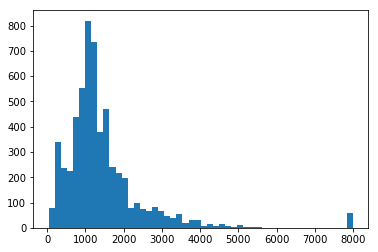

In [64]:

plt.hist(y_train, bins=50);

In [65]:
y_train.max()

7999.0

In [66]:
np.sum(y_train == y_train.max()) / len(y_train)

0.01025551885972536

In [67]:
y[y > 7000]

array([ 7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,  7999.,
        7999.,  7999.,  7999.])

In [69]:
# Drop 7999 as we can't learn anything from that
X_selected_ = X_selected[y<7999]
y_ = y[y<7999]
X_trainval, X_test, y_trainval, y_test = train_test_split(X_selected_, y_, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

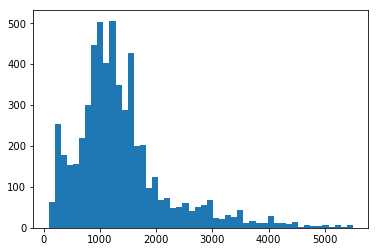

In [69]:
plt.hist(y_train, bins=50);

In [55]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV, LassoLarsCV, Lars, Ridge, LassoLars
from sklearn.feature_selection import VarianceThreshold

ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                                      RidgeCV())
ohe_interactions_pipe.fit(X_train, y_train).score(X_val, y_val)

0.51661103340822212

We can see that our last changes did not particularly improve the model

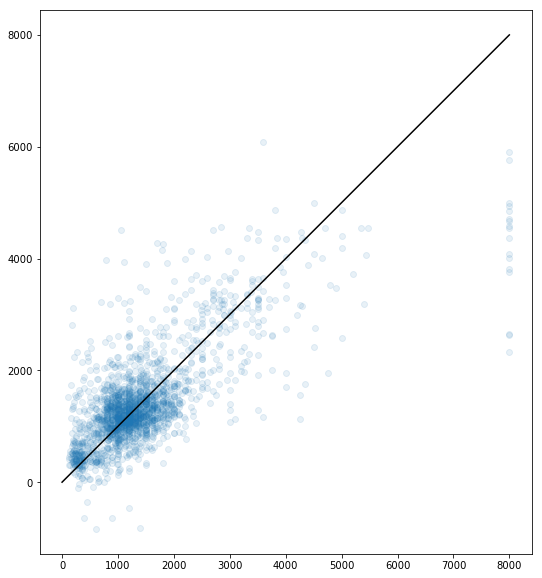

In [56]:

plt.figure(figsize=(10, 10))
plt.scatter(y_val, ohe_interactions_pipe.predict(X_val), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

Another improvement that can be tried is the Box Cox transformation which aim is 
the make the distribution of the rsponse variable closer to a normal one.
The reason is simply that a normal distribution of the response variable works better
with the linear regression models, that make some normality underlying asumptions

In [57]:

from scipy.stats import boxcox

In [58]:
y_train_bc, l = boxcox(y_train)

In [59]:
l

0.15854092123716929

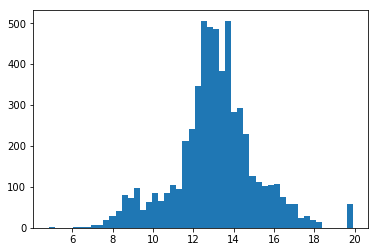

In [60]:
plt.hist(y_train_bc, bins=50);

In [61]:
1 / l

6.3075198011751805

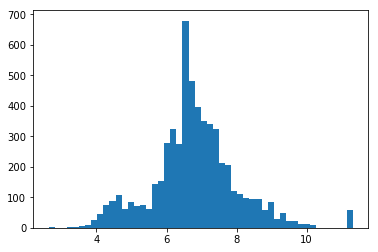

In [62]:
plt.hist(y_train ** .27, bins=50);

In [63]:
ohe_interactions_pipe = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(interaction_only=True), VarianceThreshold(),
                                      RidgeCV())
ohe_interactions_pipe.fit(X_train, y_train ** .27).score(X_val, y_val ** .27)

0.543129155193115

In [64]:
from sklearn.metrics import r2_score
r2_score(y_val, ohe_interactions_pipe.predict(X_val) ** (1/.27))

0.55008930810035128

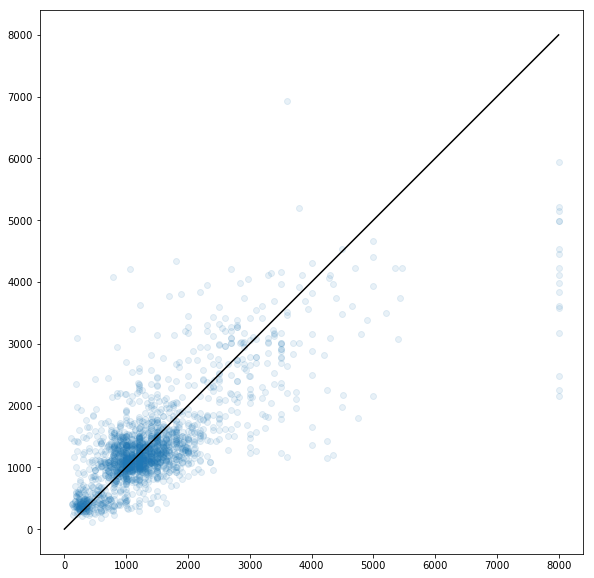

In [65]:
plt.figure(figsize=(10, 10))
plt.scatter(y_val, ohe_interactions_pipe.predict(X_val)** (1/.27), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

In [70]:
grr = pd.DataFrame(X_selected_.astype(np.int), columns=data_nr.columns[select.get_support()])
df_dummies = pd.get_dummies(grr, columns=grr.columns, prefix_sep="$")

In [71]:
X_dummies_ = df_dummies.values
X_trainval, X_test, y_trainval, y_test = train_test_split(X_dummies_, y_, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

Finally, after going back to the features description, we realized that the new_csr feature was an indicator of rent stabilized condominium. This means that the rent for them are not f=determined by the market. Therefore, we should not includ them in a model that is going to predict market prices since they are misleading information and we arre going to retrain a model without them

In [72]:
data_['new_csr'].value_counts()

80    3658
30    3533
31    1221
5      858
95     422
85     217
21     164
90     132
23      10
20      10
22       4
Name: new_csr, dtype: int64

In [73]:
df_dummies.columns

Index(['boro$1', 'boro$2', 'boro$3', 'boro$4', 'boro$5', 'uf1_4$1', 'uf1_4$8',
       'uf1_4$9', 'uf1_7$1', 'uf1_7$8',
       ...
       'new_csr$20', 'new_csr$21', 'new_csr$22', 'new_csr$23', 'new_csr$30',
       'new_csr$31', 'new_csr$80', 'new_csr$85', 'new_csr$90', 'new_csr$95'],
      dtype='object', length=117)

In [74]:
y_[(df_dummies['new_csr$80'] == 1).values]

array([ 1500.,   750.,  1650., ...,  1500.,   700.,   650.])

In [75]:
# only keep non-rent regulated
X_dummies_ = df_dummies[df_dummies['new_csr$80'] == 1].values
X_trainval, X_test, y_trainval, y_test = train_test_split(X_dummies_, y_[(df_dummies['new_csr$80'] == 1).values], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=0)

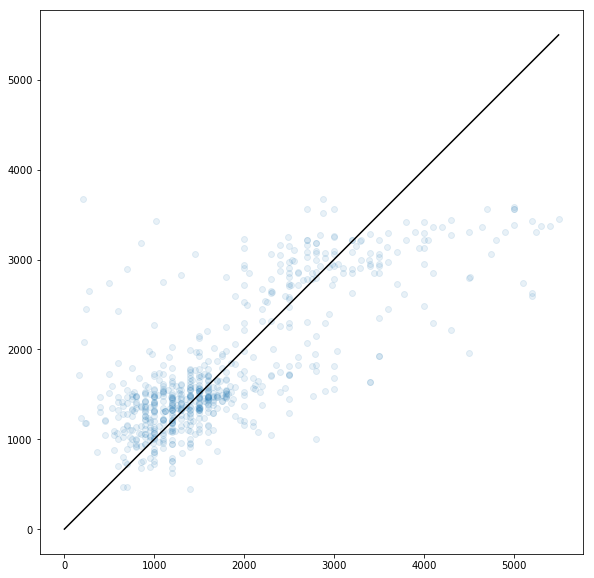

In [76]:
ridge = RidgeCV().fit(X_train, y_train)

plt.figure(figsize=(10, 10))
plt.scatter(y_val, ridge.predict(X_val), alpha=.1)
plt.gca().set_aspect("equal")
plt.plot([0, y_val.max()], [0, y_val.max()], c='k')

As inferred, the models trained on this new dataset perform significantly better without need for heavy data engineering

In [77]:
ridge.score(X_train, y_train)

0.59354813241342974

In [78]:
ridge.score(X_val, y_val)

0.58242155476081181

In [79]:
ridge.coef_

array([ -3.23185144e+02,  -9.02141446e+01,   8.29381026e+02,
        -1.05077720e+02,  -3.10904018e+02,  -2.32007075e+00,
        -4.31825070e+01,   4.55025778e+01,   5.35354726e-01,
         1.29503236e+01,  -1.34856784e+01,  -4.37987169e+01,
         1.29503236e+01,   3.08483933e+01,   3.76072798e+01,
        -4.59370313e+01,   8.32975154e+00,   4.14853482e+01,
        -4.59370313e+01,   4.45168310e+00,   2.35932383e+02,
        -1.29682786e+01,  -2.22964104e+02,   4.92176232e+01,
        -1.29682786e+01,  -3.62493445e+01,   3.31743475e+01,
        -2.34570198e+01,   4.48143546e+01,  -5.45316823e+01,
         1.02292604e+02,  -2.90271526e+01,   6.60563837e+01,
        -6.03246194e+01,  -7.89972158e+01,  -4.95309596e+01,
        -5.51739958e+01,   3.89843260e+01,   6.57206294e+01,
         2.37995581e+01,   0.00000000e+00,  -2.37995581e+01,
        -1.26114524e+02,  -9.70794275e+01,   3.58872857e+01,
         2.71830484e+01,   1.60123617e+02,  -2.93515099e+01,
        -1.24868722e+01,

In [81]:
asdf = make_pipeline(PolynomialFeatures(interaction_only=True), VarianceThreshold(), RidgeCV(alphas=np.logspace(0, 4, 8)))
asdf.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('ridgecv', RidgeCV(alphas=array([  1.00000e+00,   3.72759e+00,   1.38950e+01,   5.17947e+01,
         1.93070e+02,   7.19686e+02,   2.68270e+03,   1.00000e+04]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False))])

In [122]:
asdf.named_steps['ridgecv'].alpha_

193.06977288832496

In [123]:
asdf.score(X_train, y_train)

0.66216874235517531

In [124]:
asdf.score(X_val, y_val)

0.58103571982054314

Finally, we can see the important features according to the ridge model

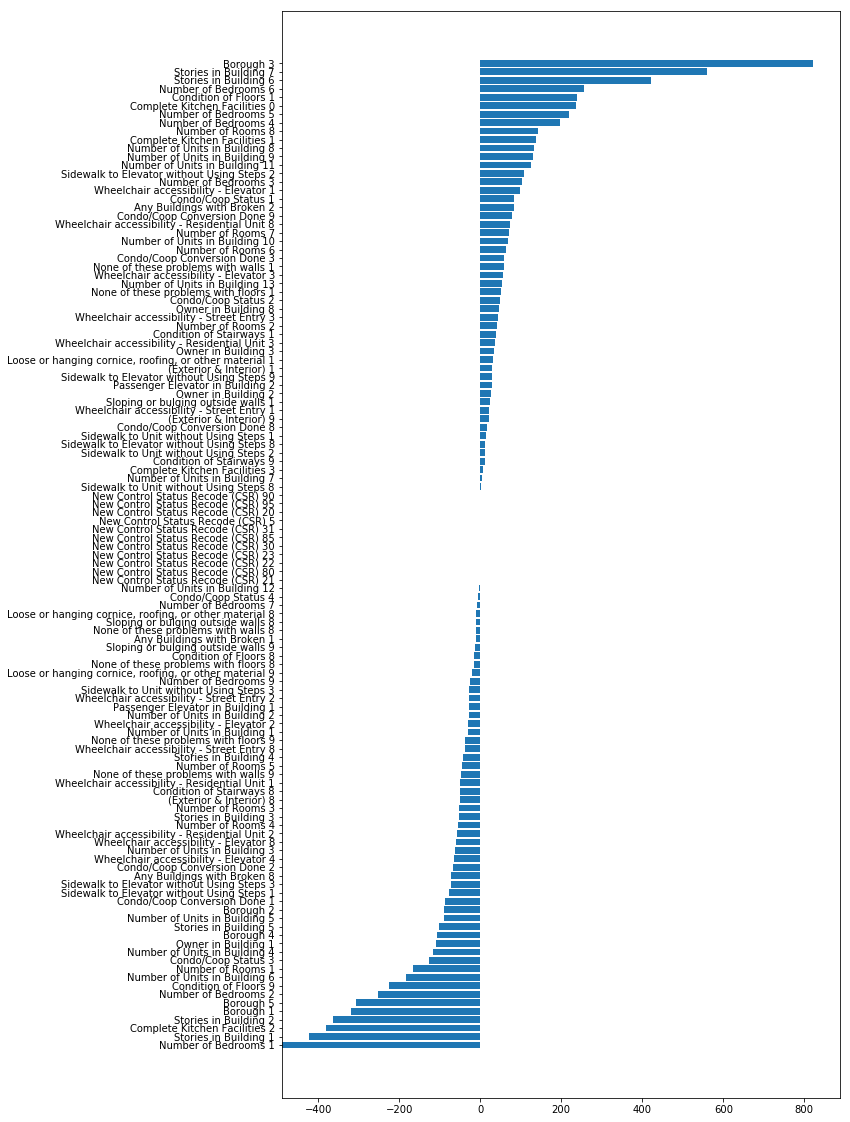

In [125]:
plt.figure(figsize=(10, 20))
inds = np.argsort(ridge.coef_)
plt.barh(range(len(inds)), ridge.coef_[inds])
plt.yticks(range(len(inds)), [feature_mapping[x.split("$")[0]] + " " + x.split("$")[1] for x in df_dummies.columns[inds]]);